# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = "Болычев".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

В своей работе буду пользоваться следующим определением $L$:
$$
L = - \sum_i \log\left(\sigma\left(y^{(i)} g\left(x^{(i)}\right)\right)\right) + \frac{1}{C}\sum_{k=1}^{m}w_k^2
$$
Таким образом
$$ \frac{\partial L}{\partial w_j} = \frac{\partial}{\partial w_j} \left\{- \sum_i \log\left(\sigma\left(y^{(i)} g\left(x^{(i)}\right)\right)\right) + \frac{1}{C}\sum_{k=1}^{m}w_k^2\right\} = -\sum_i \left(1 - \sigma\left(y^{(i)} g\left(x^{(i)}\right)\right)\right)y^{(i)}x^{(i)}_j + \frac{2}{C} w_j 
$$

## Имплементация (5 баллов)

In [177]:
#%%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit as sigmoid


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

    def SDG(self, X, y):
        weights = np.random.normal(size=1 + X.shape[1])
        N = X.shape[0]

        intercept = np.ones((X.shape[0], 1))
        oned_X = np.hstack((intercept, X))
        self.LogLossRegulList = list()
        for i in range(self.max_epoch):
            shuffled_objs = np.arange(N)
            np.random.shuffle(shuffled_objs)
            alpha = self.alpha / (1 + i / N)
            for i in shuffled_objs:
                sigmoid_val = 1 - sigmoid(np.dot(weights, oned_X[i]) * y[i])
                gradient_log_loss = -alpha * sigmoid_val * y[i] * oned_X[i]
                gradient_regularization = weights * 2 * alpha / (N * self.C)
                gradient_regularization[0] = 0
                weights = weights -\
                    (gradient_log_loss + gradient_regularization)
            arg = np.log(sigmoid(np.dot(oned_X, weights) * y))
            self.LogLossRegulList.append(-np.sum(arg) +
                                         1 / self.C * np.sum(weights[1:]**2))
        return weights

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.weights = self.SDG(X, y)

        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''

        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = np.sign(self.weights[0] + np.dot(X, self.weights[1:]))

        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        class_plus_1 = sigmoid(self.weights[0] + np.dot(X, self.weights[1:]))
        class_minus_1 = 1 - class_plus_1

        y_hat_proba = np.vstack([class_plus_1, class_minus_1]).T

        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

[-3.19676456  0.75564692 -0.58396156]


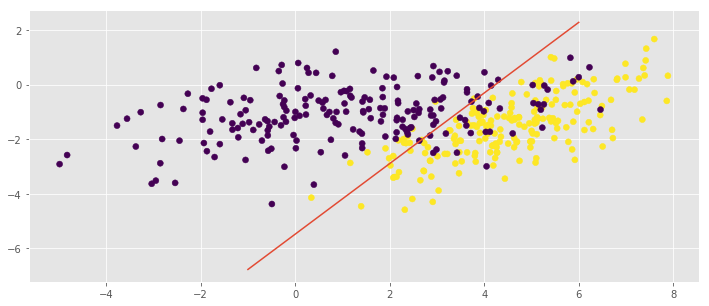

In [182]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[1 + np.zeros(200), -1 + np.zeros(200)]

plt.scatter(X[:, 0], X[:, 1], c=y)
my_log_reg = MySGDClassifier(C=0.04, alpha=0.01, max_epoch=100)
my_log_reg.fit(X, y)
print(my_log_reg.weights)
x = np.arange(-1, 6, 0.001)
Y = -my_log_reg.weights[1] / my_log_reg.weights[2] * x -\
    my_log_reg.weights[0] / my_log_reg.weights[2]
plt.plot(x, Y)
plt.show()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [405]:
from sklearn.datasets import make_classification

In [406]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

0.01
0.05
0.1


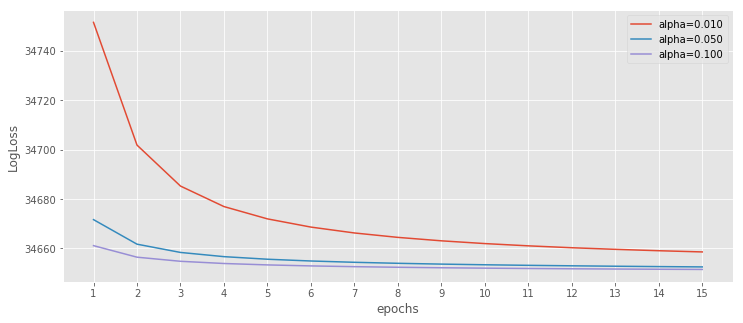

In [407]:
# Задаем параметры графика
ax = plt.subplot(111)

n_epochs = 15
for alpha_val in [0.01, 0.05, 0.1]:
    print(alpha_val)
    my_log_reg = MySGDClassifier(C=2, alpha=alpha_val, max_epoch=n_epochs)
    my_log_reg.fit(X, y)
    plt.plot(1 + np.arange(n_epochs), np.array(my_log_reg.LogLossRegulList),
            label="alpha=%.3f" % alpha_val)

# Прихорашиваем график
ax.set_xticks(1 + np.arange(n_epochs))
leg = plt.legend(loc='upper right', ncol=1)
plt.ylabel("LogLoss")
plt.xlabel("epochs")
plt.show()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [337]:
"""Вычисляем веса"""
n_epochs = 10
C_values = np.logspace(3, -3, 10)
weights = list()
for C_val in C_values:
    print(C_val)
    my_log_reg = MySGDClassifier(C = C_val, alpha = 0.01, max_epoch = n_epochs)
    my_log_reg.fit(X, y)
    weights.append(my_log_reg.weights)

1000.0
215.44346900318845
46.4158883361278
10.0
2.1544346900318843
0.4641588833612782
0.1
0.021544346900318867
0.004641588833612782
0.001


Веса логистической регрессии имеют разный порядок, поэтому для изображения на одном графике их приходится нормировать. В качестве нормы вектора берём
$$||a|| := \max_{i}\left|a\right|$$
Я выведу несколько изображений: для нормированных весов и для каждого веса в отдельности. 

Начнём с нормированных.

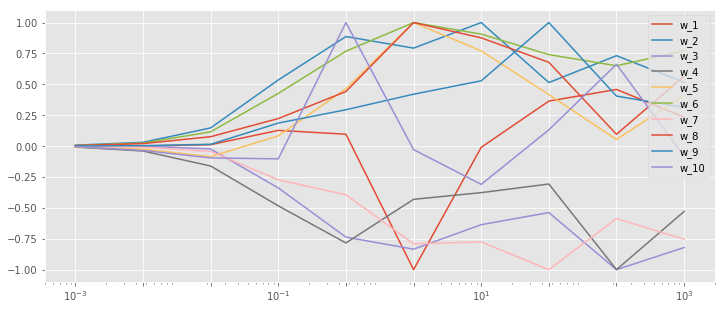

In [431]:
ax = plt.subplot(111)
weights = np.array(weights)
for i in range(1, weights.shape[1]):
    ax.plot(C_values, weights[:,i] / np.amax(np.abs(weights[:,i])), label="w_%d" % i)
leg = plt.legend(loc='upper right', ncol=1)
ax.set_xscale('log')
ax.set_xticks(C_values)
plt.show()

Теперь выведем график для каждого веса в отдельности

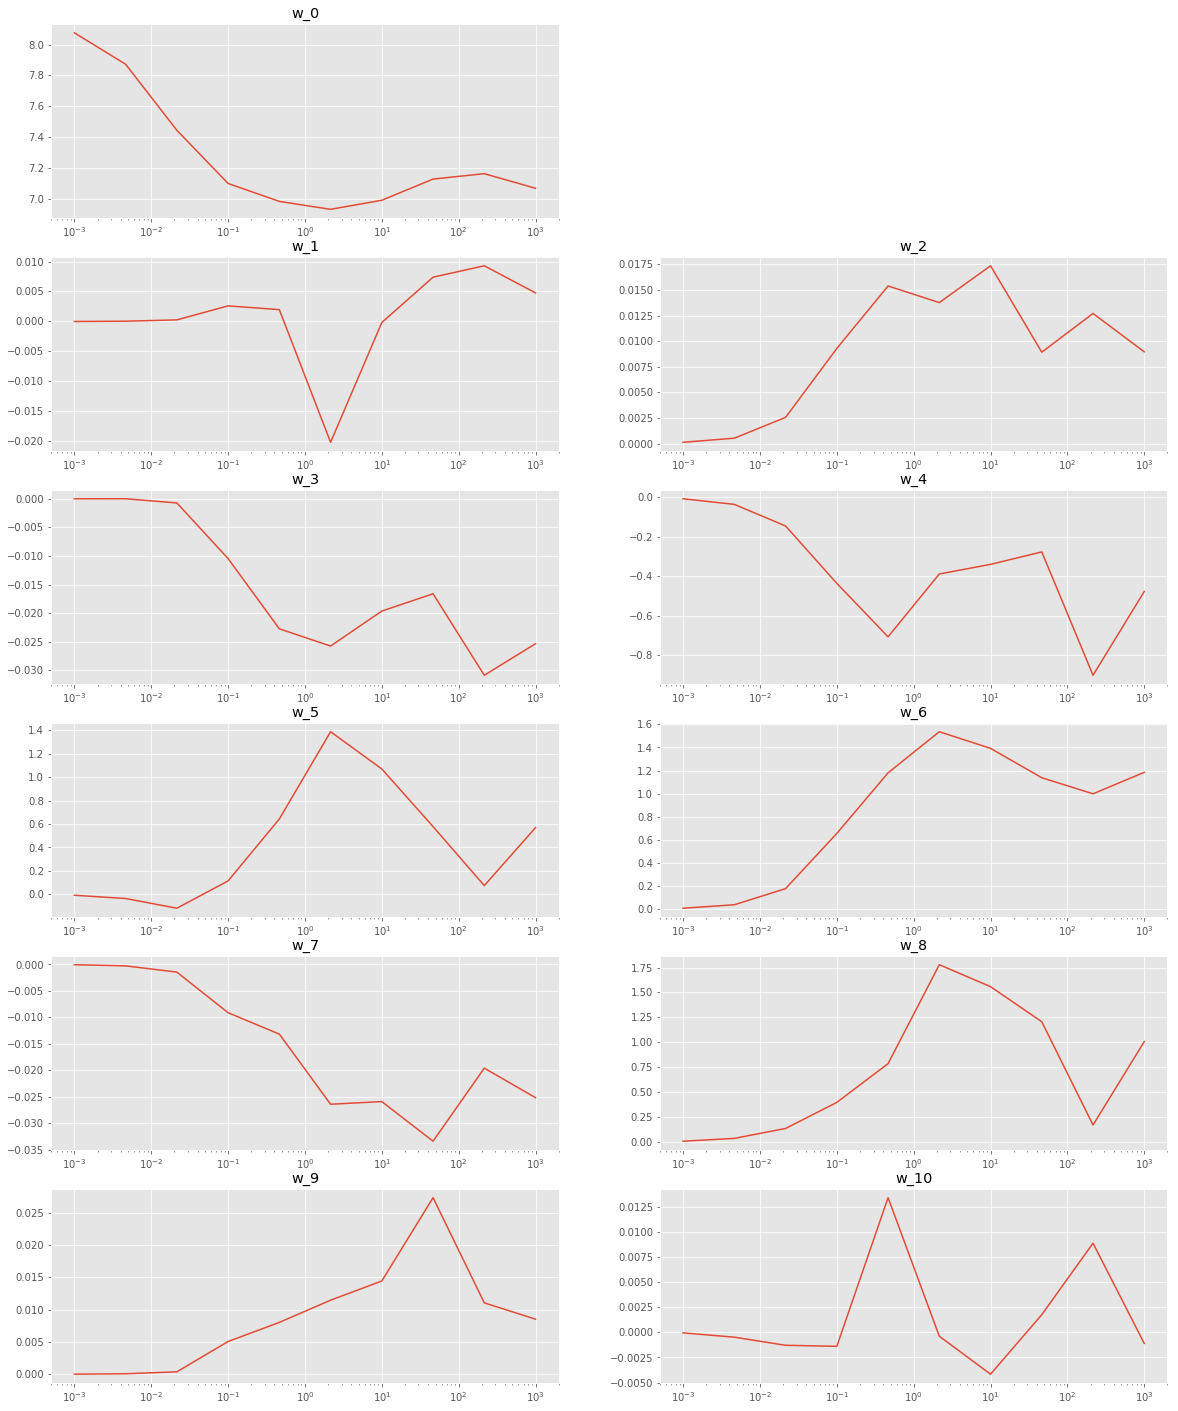

In [432]:
plt.figure(figsize=(20,25))
weights = np.array(weights)
for i in range(weights.shape[1]):
    if i == 0:
        ax = plt.subplot(6,2,1)
    else:
        ax = plt.subplot(6,2,2+i)
    plt.plot(C_values, weights[:,i])
    plt.title("w_%d" % i)
    ax.set_xscale('log')
#leg = plt.legend(loc='upper right', ncol=1)
#ax.set_xscale('log')
#ax.set_xticks(C_values)
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [75]:
#Загрузка данных целиком

df_list = []
for chunk in range(1, 5):
    filepath = './lin_model_hw/trainingData_tabular/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)


# Загрузка одной части данных
#filepath = './lin_model_hw/trainingData_tabular/trainingData_tabular_chunk1.csv'
#df_data = pd.read_csv(filepath, sep=',')

In [76]:
df_data.shape

(2000000, 45)

In [77]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [78]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [11]:
df_list = []
for chunk in range(5, 8):
    filepath = './lin_model_hw/deprecated_testData_tabular/testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list)
# для удобства
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [13]:
# для удобства
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [25]:
uni_dict_test = dict()

for col in df_data_test.columns:
    length = len(np.unique(df_data_test[col]))
    uni_dict_test[col] = length
    if (length <= 10):
        print(col, length, np.unique(df_data_test[col]))

opponent_attack 6 [0 1 3 4 5 7]
opponent_hero_card_id 9 [  25  326  390  494  612  754  798  981 1235]
opponent_special_skill_used 2 [0 1]
opponent_weapon_durability 5 [0 1 2 3 4]
opponent_fatigue_damage 8 [0 1 2 3 4 5 6 7]
opponent_played_minions_count 8 [0 1 2 3 4 5 6 7]
player_attack 8 [0 1 2 3 4 5 6 7]
player_hero_card_id 9 [  25  326  390  494  612  754  798  981 1235]
player_special_skill_used 2 [0 1]
player_weapon_durability 5 [0 1 2 3 4]
player_crystals_all 10 [ 1  2  3  4  5  6  7  8  9 10]
player_fatigue_damage 8 [0 1 2 3 4 5 6 7]
player_played_minions_count 8 [0 1 2 3 4 5 6 7]
opponent_played_nOfCards 8 [0 1 2 3 4 5 6 7]
player_played_nOfCards 8 [0 1 2 3 4 5 6 7]
player_hand_nOfSpells 8 [0 1 2 3 4 5 6 7]
player_hand_nOfWeapons 5 [0 1 2 3 4]


In [394]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [79]:
## Youd Code Here
print("player:", len(np.unique(df_data.player_hero_card_id)), np.unique(df_data.player_hero_card_id))
print("opponent:", len(np.unique(df_data.opponent_hero_card_id)), np.unique(df_data.opponent_hero_card_id))

player: 9 [  25  326  390  494  612  754  798  981 1235]
opponent: 9 [  25  326  390  494  612  754  798  981 1235]


Как видим, количество уникальных карт равно 9. 

Теперь попробуем разобраться с катериальными переменными. Для начала выведем колонки у которых np.unique <= 20

In [80]:
uni_dict = dict()

for col in df_data.columns:
    length = len(np.unique(df_data[col]))
    uni_dict[col] = length
    if (length <= 20):
        print(col, length, np.unique(df_data[col]))

decision 2 [0 1]
opponent_attack 6 [0 1 3 4 5 7]
opponent_hero_card_id 9 [  25  326  390  494  612  754  798  981 1235]
opponent_special_skill_used 2 [0 1]
opponent_weapon_durability 5 [0 1 2 3 4]
opponent_crystals_all 11 [ 0  1  2  3  4  5  6  7  8  9 10]
opponent_crystals_current 11 [ 0  1  2  3  4  5  6  7  8  9 10]
opponent_fatigue_damage 8 [0 1 2 3 4 5 6 7]
opponent_hand_count 11 [ 0  1  2  3  4  5  6  7  8  9 10]
opponent_played_minions_count 8 [0 1 2 3 4 5 6 7]
player_attack 8 [0 1 2 3 4 5 6 7]
player_hero_card_id 9 [  25  326  390  494  612  754  798  981 1235]
player_special_skill_used 2 [0 1]
player_weapon_durability 5 [0 1 2 3 4]
player_crystals_all 10 [ 1  2  3  4  5  6  7  8  9 10]
player_crystals_current 11 [ 0  1  2  3  4  5  6  7  8  9 10]
player_fatigue_damage 7 [0 1 2 3 4 5 7]
player_hand_count 11 [ 0  1  2  3  4  5  6  7  8  9 10]
player_played_minions_count 8 [0 1 2 3 4 5 6 7]
opponent_played_nOfCards 8 [0 1 2 3 4 5 6 7]
player_played_nOfCards 8 [0 1 2 3 4 5 6 7]
pl

Итак, катеригориальные переменные за исключением hero_card имеют значения от 0 до n. Заметим, что в
player_fatigue_damage пропушена категория 6. Поэтому добавим столбец искусственно.

In [82]:
cols = df_data.columns[1:]

for col in cols:
    length = len(np.unique(df_data[col]))
    # Если переменная категориальная
    if (length <= 20 and length >= 2):
        onehot = pd.get_dummies(df_data[col], prefix = col)
        if col == "player_fatigue_damage":
            onehot.insert(loc=6, column='player_fatigue_damage_6', value=np.zeros(onehot.shape[0], dtype = int))
        df_data = pd.concat([df_data,onehot], axis= 1).drop(col,  axis=1)

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [126]:
## Youd Code Here
X = df_data.iloc[:,1:].astype('float32')
y = 2 * df_data.decision - 1

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=0.2, alpha=0.1, max_epoch=10))])

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('std', StandardScaler()), 
                 ('clf', MySGDClassifier(C=0.15, alpha=0.1, max_epoch=10))])
pipe.fit(X.values[:500000], y.values[:500000])

/Users/anton/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=0.15, alpha=0.1, max_epoch=10))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [154]:
df_list = []
for chunk in range(5, 8):
    filepath = './lin_model_hw/deprecated_testData_tabular/testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list)
# для удобства
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [159]:
y_test = pd.read_csv('./lin_model_hw/deprecated_testLabels.txt', header=None)

In [168]:
df_data_test = df_data_test.drop("decision",axis = 1)

Сравним тестовую выборку с тренировочной

In [155]:
for col in df_data_test.columns:
    length = len(np.unique(df_data_test[col]))
    uni_dict_test[col] = length
    if (length <= 10):
        print(col, length - uni_dict[col], np.unique(df_data_test[col]))

opponent_attack 0 [0 1 3 4 5 7]
opponent_hero_card_id 0 [  25  326  390  494  612  754  798  981 1235]
opponent_special_skill_used 0 [0 1]
opponent_weapon_durability 0 [0 1 2 3 4]
opponent_fatigue_damage 0 [0 1 2 3 4 5 6 7]
opponent_played_minions_count 0 [0 1 2 3 4 5 6 7]
player_attack 0 [0 1 2 3 4 5 6 7]
player_hero_card_id 0 [  25  326  390  494  612  754  798  981 1235]
player_special_skill_used 0 [0 1]
player_weapon_durability 0 [0 1 2 3 4]
player_crystals_all 0 [ 1  2  3  4  5  6  7  8  9 10]
player_fatigue_damage 1 [0 1 2 3 4 5 6 7]
player_played_minions_count 0 [0 1 2 3 4 5 6 7]
opponent_played_nOfCards 0 [0 1 2 3 4 5 6 7]
player_played_nOfCards 0 [0 1 2 3 4 5 6 7]
player_hand_nOfSpells -1 [0 1 2 3 4 5 6 7]
player_hand_nOfWeapons 0 [0 1 2 3 4]


player_hand_nOfSpells имеет на 1 меньшую размерность => добавим столбец самостоятельно

In [158]:
cols = df_data_test.columns

for col in cols:
    length = len(np.unique(df_data_test[col]))
    # Если переменная категориальная
    if (length <= 20 and length >= 2):
        onehot = pd.get_dummies(df_data_test[col], prefix = col)
        if col == "player_hand_nOfSpells":
            onehot["player_hand_nOfSpells_8"] = np.zeros(onehot.shape[0], dtype = int)
        df_data_test = pd.concat([df_data_test,onehot], axis= 1).drop(col,  axis=1)

In [171]:
predicted = pipe.predict(df_data_test.values[:500000])

/Users/anton/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


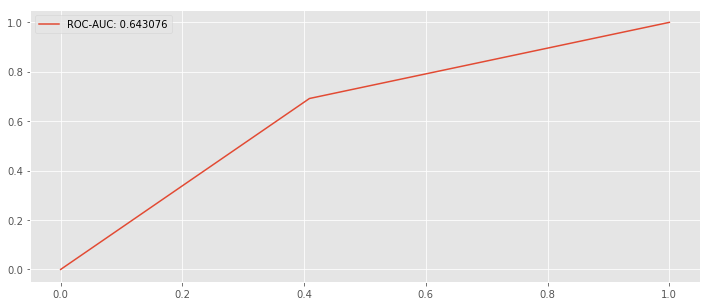

In [175]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, trp, _ = roc_curve(y_test.values[:500000], predictions)
score = roc_auc_score(predicted, y_test.values[:500000])
plt.plot(fpr, trp, label="ROC-AUC: %f" % score)
plt.legend()
plt.show()